# Defining a target using two stocks

## Goal
Imagine that we can perfectly predict `a certain` target. Can we come out with a trading strategy based on this model? How often and accurate do our models need to be able to do this?

In this jupyter notebook we simulate the following strategy. Imagine that we have two assets (in this case 'GS', 'MSFT') and we can predict which one is is going to grow more in the next minute


## Main takeouts
This notebook suggest that the performance required to outperform an strategy that consists of only holding one of the assets for the whole time is unexpectedly low.

For instance a precision of 0.55 and recall of 0.2 will produce greate results. Notice moreover that our target is balanced (i.e. our base rate is more or less 0.5).

Notice that this strategy implies trading once every 5 minutes (something rather expensive), and a recall of 0.2 in this set up is not realistic


In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
import pandas as pd
import random
import numpy as np
from datetime import datetime

In [3]:
minutesPerDay = 390
def simulateMultipleStrategies(S1, S2, precision, recall, numExperiments=100, sizeExperiment=20*minutesPerDay):
    """ Comment
    """
    S = pd.concat([S1,S2], axis=1).dropna()
    S.columns=['S1', 'S2']
    lenS=len(S)
    experimentStarts = random.choices(range(lenS-sizeExperiment), k=numExperiments)

    endPriceS1=[]
    endPriceS2= []
    endPriceStragegy = []
    movementsStrategy = []
    
    for es in experimentStarts:
        T1=S[es:es+sizeExperiment]['S1']
        T2=S[es:es+sizeExperiment]['S2']
        end1, end2, endStrategy, numMovements = simulateStrategyWithNoisyPredictor(T1, T2, precision, recall)
        endPriceS1.append(end1)
        endPriceS2.append(end2)
        endPriceStragegy.append(endStrategy)
        movementsStrategy.append(numMovements)
    return endPriceS1, endPriceS2, endPriceStragegy, movementsStrategy


def simulateStrategyWithNoisyPredictor(S1, S2, precision, recall):
    """ Comment
    """
    lenS = len(S1)
    I1 = (1+S1.pct_change()).fillna(1).values
    I2 = (1+S2.pct_change()).fillna(1).values
    SymbolMin = ['S1' if I1[i]<I2[i] else 'S2' for i in range(lenS)]
    SymbolMax = ['S1' if I1[i]>I2[i] else 'S2' for i in range(lenS)]
    
    numPredictions = int(lenS*recall/precision)
    numCorrectPredictions = int(numPredictions*precision)
    predictionIndexes = random.sample(range(lenS), numPredictions)
    correctPredictionIndexes = predictionIndexes[:numCorrectPredictions]
    wrongPredictionIndexes = predictionIndexes[numCorrectPredictions:]
        
    SymbolStrategy = [None]*lenS
    for goodIndex in correctPredictionIndexes: SymbolStrategy[goodIndex]=SymbolMax[goodIndex] 
    for badIndex in wrongPredictionIndexes: SymbolStrategy[badIndex]=SymbolMin[badIndex]
    SymbolStrategy[0] = random.choice(['S1','S2'])
    for i in range(1, lenS): SymbolStrategy[i]=SymbolStrategy[i-1] if SymbolStrategy[i]==None else SymbolStrategy[i]    
    Strategy = [I1[i] if SymbolStrategy[i]=='S1' else I2[i] for i in range(lenS)] # more like the increases
    
    numMovements = 0
    for i in range(1,lenS): numMovements+=(1 if SymbolStrategy[i]!=SymbolStrategy[i-1] else 0)    
    return np.prod(I1), np.prod(I2), np.prod(Strategy), numMovements
    

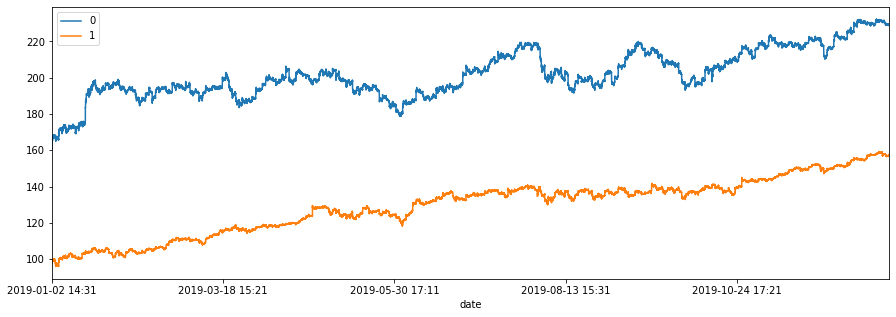

In [4]:
df = pd.read_csv('data/quantopian/minuteIntraday/GS.csv').drop(columns=['volume']).set_index('date')
S1 = df.mean(axis=1)
df = pd.read_csv('data/quantopian/minuteIntraday/MSFT.csv').drop(columns=['volume']).set_index('date')
S2 = df.mean(axis=1)
pd.concat([S1,S2], axis=1).plot(figsize=(15,5));

In [5]:
endStock1, endStock2, endStrategy, movementsStrategy = simulateMultipleStrategies(S1, S2, precision = 0.55, recall=0.2, numExperiments=200, sizeExperiment=20*390)

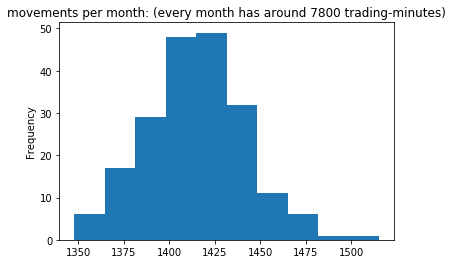

In [6]:
pd.Series(movementsStrategy).plot.hist(title='movements per month: (every month has around 7800 trading-minutes)');

In [7]:
dr=pd.DataFrame({'endStock1':endStock1, 'endStock2':endStock2, 'endStrategy':endStrategy})

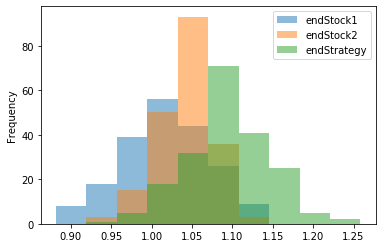

In [8]:
dr.plot.hist(bins=10, alpha=0.5);

In [9]:
dr['bestStock']=dr[['endStock1', 'endStock2']].max(axis=1)

In [10]:
dr['difference']=dr.endStrategy-dr.bestStock

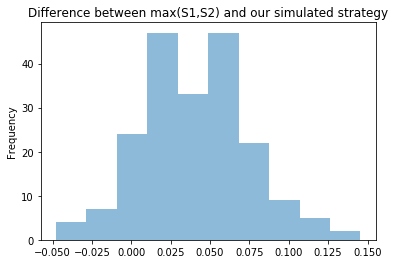

In [11]:
dr.difference.plot.hist(title='Difference between max(S1,S2) and our simulated strategy', bins=10, alpha=0.5);

In [12]:
dr.difference.describe()

count    200.000000
mean       0.040485
std        0.033674
min       -0.047794
25%        0.016590
50%        0.039730
75%        0.060758
max        0.145470
Name: difference, dtype: float64